In [1]:
import os
import matlab.engine # the matlab engine for python
import cv2
import numpy as np
from pathlib import Path

# from curvelax.numpy_dct import perform_fdct
import matplotlib.pyplot as plt

from diffcurve.fdct2d.curvelet_2d import get_curvelet_system
from diffcurve.utils import get_project_root

project_root = get_project_root()

lena_file = Path.joinpath(project_root, "tests/Lena.jpg")

lena_img_square_even = cv2.imread(str(lena_file), 0).astype(float) / 255

In [2]:
def get_curvelet_decomposition(img, dct_kwargs):
    eng = matlab.engine.start_matlab()
    zeros = np.zeros_like(img)
    eng.cd(str(Path.joinpath(project_root, "diffcurve/fdct2d")))
    zero_coeffs = eng.fdct_wrapping(zeros,
                                    dct_kwargs['is_real'],
                                    dct_kwargs['finest'],
                                    dct_kwargs['nbscales'],
                                    dct_kwargs['nbangles_coarse'])

    tmp = eng.fdct_wrapping(zeros,
                            dct_kwargs['is_real'],
                            dct_kwargs['finest'],
                            dct_kwargs['nbscales'],
                            dct_kwargs['nbangles_coarse'])

    img_coeffs = eng.fdct_wrapping(img,
                                   dct_kwargs['is_real'],
                                   dct_kwargs['finest'],
                                   dct_kwargs['nbscales'],
                                   dct_kwargs['nbangles_coarse'])

    all_scales_all_wedges_curvelet_coeffs = []
    for (scale_idx, curvelets_scale) in enumerate(zero_coeffs):
        print(f'scale {scale_idx}')
        for (wedge_idx, curvelet_wedge) in  enumerate(curvelets_scale):

            tmp[scale_idx][wedge_idx] = img_coeffs[scale_idx][wedge_idx]
            out = np.array(eng.ifdct_wrapping(tmp))
            all_scales_all_wedges_curvelet_coeffs.append(out)
            tmp[scale_idx][wedge_idx] = zero_coeffs[scale_idx][wedge_idx]
    return all_scales_all_wedges_curvelet_coeffs

# loopy 

In [3]:
img = lena_img_square_even

dct_kwargs = {
    'is_real': 0.0, # complex-valued curvelets
    'finest': 2.0, # use wavelets at the finest level
    'nbscales': 6.0,
    'nbangles_coarse': 16.0}

In [4]:
matlab_decomp = get_curvelet_decomposition(img, dct_kwargs)
matlab_decomp = np.array(matlab_decomp)


scale 0
scale 1
scale 2
scale 3
scale 4
scale 5


MSE = 1.9629717476815235e-31


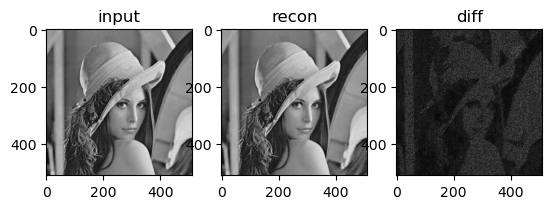

In [5]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow( img , cmap='gray' )
axes[0].set_title('input')

axes[1].imshow( matlab_decomp.sum(0).real, cmap='gray' )
axes[1].set_title('recon')

axes[2].imshow( np.abs(matlab_decomp.sum(0).real - img), cmap='gray' )
axes[2].set_title('diff')

print(f'MSE = { np.mean( (matlab_decomp.sum(0).real - img) ** 2 ) }')

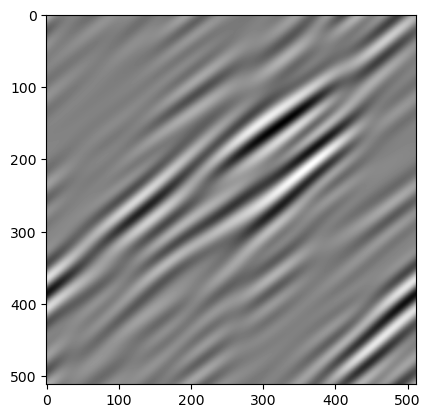

In [6]:
curvelet_idx =  1
plt.imshow( np.array(matlab_decomp)[curvelet_idx, ...].real,  cmap='gray')

# Direct 

In [7]:
curvelet_system, curvelet_coeff_dim = get_curvelet_system(512, 512, dct_kwargs)

Text(0.5, 1.0, 'spatial')

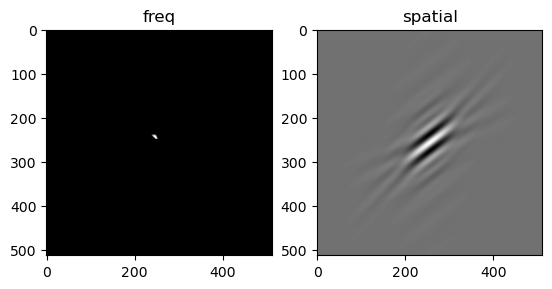

In [8]:
from diffcurve.fdct2d.numpy_frontend import perform_ifft2


fig, axes = plt.subplots(1, 2)


axes[0].imshow( (curvelet_system[curvelet_idx]).real, cmap='gray')
axes[0].set_title('freq')

axes[1].imshow( perform_ifft2(curvelet_system[curvelet_idx]).real, cmap='gray')
axes[1].set_title('spatial')

# numpy

In [9]:
# def numpy_fdct_2d(img, curvelet_system):
#     # get data in frequency domain
#     x_freq = perform_fft2(img)
#     coeffs = np.zeros_like(curvelet_system)
#     for j in range(coeffs.shape[0]):
#         coeffs[j, ...] = perform_ifft2(x_freq * np.conj(curvelet_system[j,...]))
#     return coeffs


# def numpy_ifdct_2d(coeffs, curvelet_system, curvelet_support_size):

#     decomp = np.zeros_like(coeffs)
#     for j in range(coeffs.shape[0]):
#         decomp[j, ...] = perform_ifft2(perform_fft2(coeffs[j,...]) * curvelet_system[j,...]) * curvelet_support_size[j]
#     return decomp

# jax

In [10]:
# from curvelax.utils import jax_perform_fft2, jax_perform_ifft2
# import jax.numpy as jnp
# import jax


# curvelet_support_size =  np.prod(np.array(curvelet_coeff_dim), 1)


# def jax_fdct_2d(img, curvelet_system):
#     x_freq = jax_perform_fft2(img)
#     conj_curvelet_system = jnp.conj(curvelet_system)
#     coeffs  = jax.vmap(jax_perform_ifft2)(x_freq * conj_curvelet_system)
#     return coeffs


# def jax_ifdct_2d(coeffs, curvelet_system, curvelet_support_size):
#     coeffs_freq = jax.vmap(jax_perform_fft2)(coeffs)
#     return jax.vmap(jax_perform_ifft2)(coeffs_freq * curvelet_system) * jnp.expand_dims(curvelet_support_size, [1,2])

In [11]:
import importlib
import diffcurve
importlib.reload(diffcurve)


from diffcurve.fdct2d.jax_frontend import jax_fdct_2d, jax_ifdct_2d

from diffcurve.fdct2d.numpy_frontend import numpy_fdct_2d, numpy_ifdct_2d


from diffcurve.fdct2d.torch_frontend import torch_fdct_2d, torch_ifdct_2d


In [12]:

curvelet_support_size =  np.prod(curvelet_coeff_dim, 1)


jax_coeff = jax_fdct_2d(img, curvelet_system)

jax_decomp = jax_ifdct_2d(jax_coeff, curvelet_system, curvelet_support_size)

numpy_coeff = numpy_fdct_2d(img, curvelet_system)

numpy_decomp = numpy_ifdct_2d(numpy_coeff, curvelet_system, curvelet_support_size)


In [13]:
import torch

In [14]:
# '''Get curvelet system'''
# import torch
# import functorch

# def torch_perform_fft2(spatial_input):
#     """Perform fast fourier transform in 2D.
#     The ifftshift and fftshift shift the origin of the signal. See
#     http://www.cvl.isy.liu.se/education/undergraduate/tsbb14/laborationerFiler/Lab3_student.pdf
#     """

#     return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(spatial_input), norm='ortho'))

# def torch_perform_ifft2(frequency_input):
#     """Perform inverse fast fourier transform in 2D.
#     The ifftshift and fftshift shift the origin of the signal. See
#     http://www.cvl.isy.liu.se/education/undergraduate/tsbb14/laborationerFiler/Lab3_student.pdf
#     """
#     return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(frequency_input), norm='ortho'))

# vmap_torch_perform_ifft2 = functorch.vmap(torch_perform_ifft2)
# vmap_torch_perform_fft2 = functorch.vmap(torch_perform_fft2)

# def torch_fdct_2d(img, curvelet_system):
#     x_freq = torch_perform_fft2(img)
#     conj_curvelet_system = torch.conj(curvelet_system)
#     coeffs  = vmap_torch_perform_ifft2(x_freq * conj_curvelet_system)
#     return coeffs


# def torch_ifdct_2d(coeffs, curvelet_system, curvelet_support_size):
#     coeffs_freq = vmap_torch_perform_fft2(coeffs)
#     unsqueezed_support_size = curvelet_support_size[..., None, None]
#     return vmap_torch_perform_ifft2(coeffs_freq * curvelet_system) * unsqueezed_support_size


In [15]:
torch_coeff = torch_fdct_2d(torch.from_numpy(img), torch.from_numpy(curvelet_system))

torch_decomp = torch_ifdct_2d(torch_coeff, torch.from_numpy(curvelet_system), torch.from_numpy(curvelet_support_size ) )


# Compare speed

In [ ]:
%timeit numpy_ifdct_2d(numpy_fdct_2d(img, curvelet_system), curvelet_system, curvelet_support_size)


3.62 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit jax_ifdct_2d(jax_fdct_2d(img, curvelet_system), curvelet_system, curvelet_support_size)


176 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare result

In [ ]:
print(np.allclose(jax_decomp, numpy_decomp) )
print(np.allclose(jax_decomp, matlab_decomp))

True
True


In [ ]:
from diffcurve.plot_utils import plot_images, simpleaxis

<Figure size 640x480 with 0 Axes>

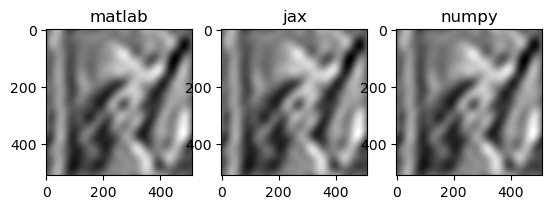

<Figure size 640x480 with 0 Axes>

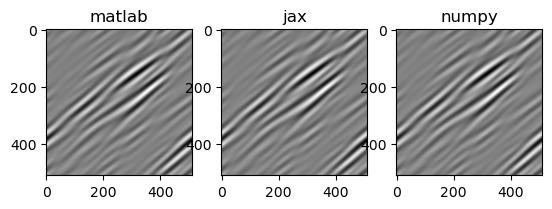

<Figure size 640x480 with 0 Axes>

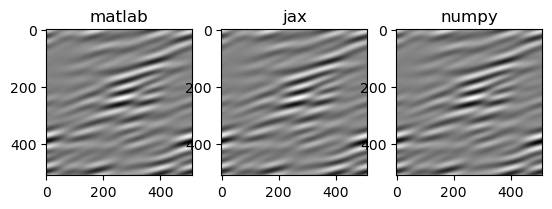

<Figure size 640x480 with 0 Axes>

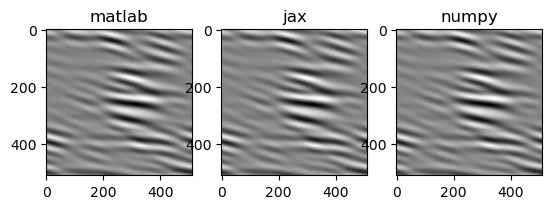

<Figure size 640x480 with 0 Axes>

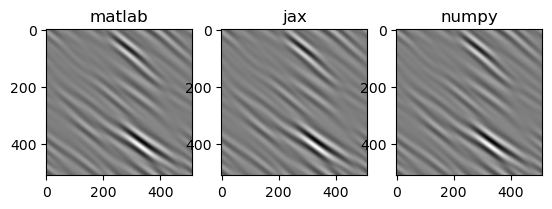

<Figure size 640x480 with 0 Axes>

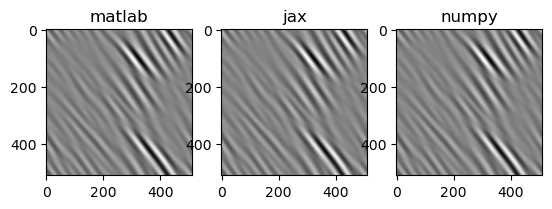

<Figure size 640x480 with 0 Axes>

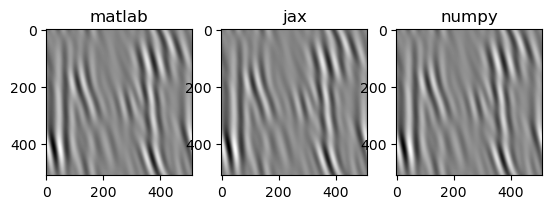

<Figure size 640x480 with 0 Axes>

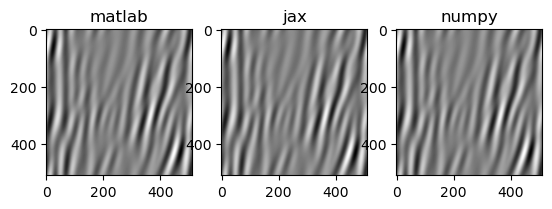

<Figure size 640x480 with 0 Axes>

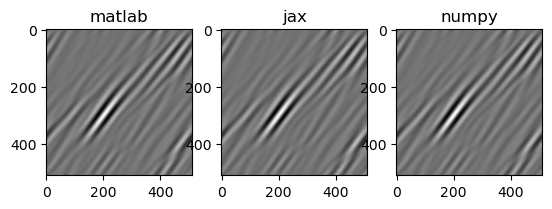

<Figure size 640x480 with 0 Axes>

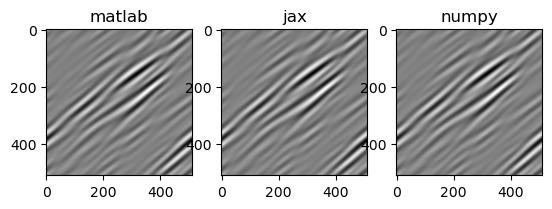

In [ ]:
for curvelet_idx in range(10):

    plt.figure()

    im, axes = plot_images([matlab_decomp[curvelet_idx].real.T, jax_decomp[curvelet_idx].real.T, numpy_decomp[curvelet_idx].real.T], vrange = 'individual', cbar='none', cmap='gray')

    axes[0].set_title('matlab')
    axes[1].set_title('jax')
    axes[2].set_title('numpy')

    plt.plot()

MSE = 1.1598556547941844e-31


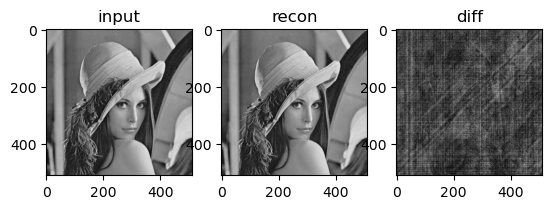

In [ ]:
# plt.imshow(jax_decomp.sum(0).real )


fig, axes = plt.subplots(1, 3)

axes[0].imshow( img, cmap='gray') 
axes[0].set_title('input')

axes[1].imshow( jax_decomp.sum(0).real, cmap='gray') 
axes[1].set_title('recon')

axes[2].imshow( np.abs(jax_decomp.sum(0).real - img), cmap='gray')
axes[2].set_title('diff')

print(f'MSE = { np.mean( (jax_decomp.sum(0).real - img) ** 2 ) }')

In [ ]:
# np.log2(85) - 3

In [ ]:
# dct_kwargs = {
#     'is_real': 0.0, #0 # complex-valued curvelets
#     'finest': 2.0, #2.0, # use wavelets at the finest level
#     'nbscales': 3.0,
#     'nbangles_coarse': 16.0}

# curvelet_system, curvelet_85_coeff_dim = get_curvelet_system(85, 85, dct_kwargs)
# curvelet_system = np.array(curvelet_system)

# np.save('curvelet_system_85', curvelet_system)
# np.save('curvelet_85_coeff_dim', curvelet_85_coeff_dim)